In [1]:
# import library
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
from io import StringIO
import Sastrawi
import joblib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /Users/ondom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ondom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ondom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import raw dataset for preprocessing
df = pd.read_csv('train_preprocess.tsv',sep ='\t', names = ["text", "sentiment"])

In [3]:
df.head()

text sentiment
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2  lokasi strategis di jalan sumatera bandung . t...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative

In [4]:
df['sentiment'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: sentiment, dtype: int64

In [5]:
# inspect the Dataframe
print(df.describe())

               text sentiment
count         11000     11000
unique        10933         3
top     tidak kesal  positive
freq              4      6416


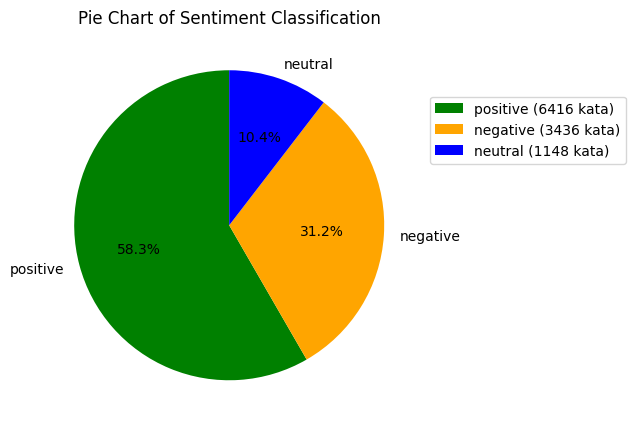

In [6]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and "label" is the column containing sentiment labels

# Count the occurrences of each sentiment label
sentiment_counts = df["sentiment"].value_counts()

# Define colors for each sentiment
colors = ['green', 'orange', 'blue']  # Add more colors as needed

# Plotting a pie chart
plt.figure(figsize=(5, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Adding a legend
legend_labels = [f'{label} ({count} kata)' for label, count in zip(sentiment_counts.index, sentiment_counts)]
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 0.85))

plt.title('Pie Chart of Sentiment Classification')
plt.show()


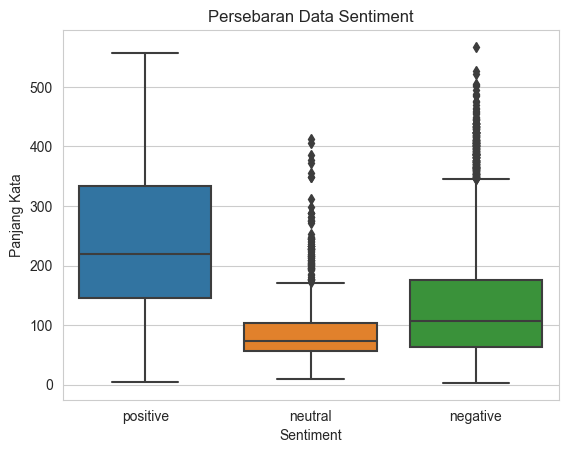

In [7]:
# Box plot
df['ln_text'] = df['text'].str.len()
sns.set_style('whitegrid')
sns.boxplot(y = df['ln_text'] , x = df['sentiment']);
plt.ylabel('Panjang Kata')
plt.xlabel('Sentiment')
plt.title('Persebaran Data Sentiment')
plt.show()

# __Text Cleansing__

In [8]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ',string)
    return string

In [9]:
df['text_clean'] = df['text'].apply(cleansing)

In [10]:
df.head()

text sentiment  ln_text  \
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive      404   
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral      102   
2  lokasi strategis di jalan sumatera bandung . t...  positive      184   
3  betapa bahagia nya diri ini saat unboxing pake...  positive       93   
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative      214   

                                          text_clean  
0  warung ini dimiliki oleh pengusaha pabrik tahu...  
1  mohon ulama lurus dan k212 mmbri hujjah partai...  
2  lokasi strategis di jalan sumatera bandung   t...  
3  betapa bahagia nya diri ini saat unboxing pake...  
4  duh   jadi mahasiswa jangan sombong dong   kas...

# __Feature Extraction Bag of Word__

In [11]:
data_preprocessed = df['text_clean'].tolist()

In [12]:
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed)

x = count_vect.transform(data_preprocessed)

In [13]:
pickle.dump(count_vect, open("feature.p", "wb"))

# __Splitting Dataset__

In [14]:
#berikut ini adalah split existing data menjadi 80% data trainning dan 20% data test

In [15]:
classes = df['sentiment']

In [16]:
classes

0        positive
1         neutral
2        positive
3        positive
4        negative
           ...   
10995    positive
10996    positive
10997     neutral
10998    negative
10999    positive
Name: sentiment, Length: 11000, dtype: object

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, classes, test_size = 0.2)

In [18]:
print(f"x_train size: {x_train.shape[0]}")
print(f"y_train size: {y_train.shape[0]}")
print(f"x_test size: {x_test.shape[0]}")
print(f"y_test size: {y_test.shape[0]}")

x_train size: 8800
y_train size: 8800
x_test size: 2200
y_test size: 2200


In [19]:
model = MLPClassifier()
model.fit(x_train, y_train)

MLPClassifier()

In [20]:
#Dump model ke dalam pickle
pickle.dump(model, open("model.p", "wb"))

# __Evaluasi Model__

In [44]:
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

    negative       0.80      0.80      0.80       698
     neutral       0.75      0.66      0.70       234
    positive       0.88      0.91      0.90      1268

    accuracy                           0.85      2200
   macro avg       0.81      0.79      0.80      2200
weighted avg       0.84      0.85      0.84      2200



# __Cross Validation__

In [22]:
#KF ini adalah unutk melihat konsistensi nilai presisi, recall, dan f1

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = classes

for iteration, data in enumerate(kf.split(x), start=1):

    data_train   = x[data[0]]
    target_train = y[data[0]]

    data_test    = x[data[1]]
    target_test  = y[data[1]]

    clf = MLPClassifier()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # for the current fold only    
    accuracy = accuracy_score(target_test,preds)

    print("Training ke-", iteration)
    print(classification_report(target_test,preds))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training ke- 1
              precision    recall  f1-score   support

    negative       0.78      0.79      0.78       680
     neutral       0.77      0.65      0.70       239
    positive       0.88      0.89      0.89      1281

    accuracy                           0.83      2200
   macro avg       0.81      0.78      0.79      2200
weighted avg       0.83      0.83      0.83      2200

Training ke- 2
              precision    recall  f1-score   support

    negative       0.80      0.77      0.79       706
     neutral       0.75      0.71      0.73       220
    positive       0.88      0.91      0.90      1274

    accuracy                           0.85      2200
   macro avg       0.81      0.80      0.81      2200
weighted avg       0.84      0.85      0.84      2200

Training ke- 3
              precision    recall  f1-score   support

    negative       0.79      0.81      0.80       682
     neutral       0.86      0.71      0.78       215
    positive       0.89      0

# __Predict__

In [23]:
# Melakukan prediksi dengan model yang telah dibuat
original_text = '''
saya mau makan
'''

text = count_vect.transform([cleansing(original_text)])

result = model.predict(text)[0]
print("Sentiment:")
print()
print(result)


Sentiment:

neutral


In [24]:
prediction_data = pd.DataFrame({'True Data':target_test.values.ravel(), 'Prediction':preds})
prediction_data.sample(20)

True Data Prediction
1021  negative   negative
477   positive   positive
479   negative   negative
773   negative   negative
746   positive   positive
77    positive   positive
2024   neutral    neutral
2129  positive   positive
20    positive   negative
670   positive   positive
386    neutral    neutral
340   negative   negative
919   positive   positive
613   positive   positive
54    positive   positive
929   positive   positive
2135  positive   positive
187   positive   positive
211   positive   negative
2038  positive   positive

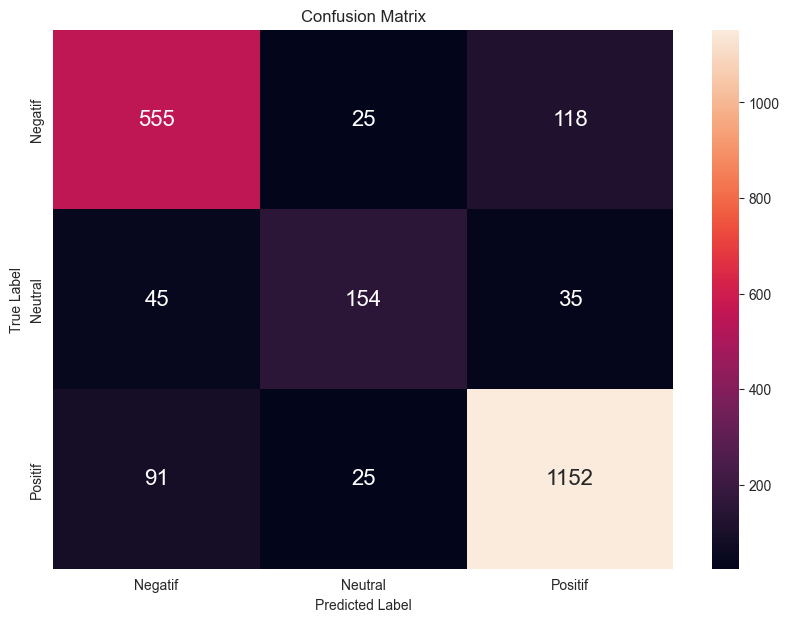

In [46]:
def plot_confusion_matrix(y_test, y_pred):  
     conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))  
     fig = plt.figure(figsize=(10, 7))  
     sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt="g", 
                xticklabels=["Negatif", "Neutral", "Positif"],
                yticklabels=["Negatif", "Neutral", "Positif"])  
     plt.title("Confusion Matrix")  
     plt.xlabel("Predicted Label")  
     plt.ylabel("True Label")  
     plt.show()
   
plot_confusion_matrix(y_test,y_pred)